In [1]:
from bs4 import BeautifulSoup as BS
import requests
from time import sleep
import numpy as np
import pandas as pd
import re
import pandas as pd
import gzip
import shutil
from datasets import load_dataset
import os
import zipfile
from io import BytesIO
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline
import seaborn as sns
from sklearn.decomposition import PCA
from wordcloud import WordCloud
import ast


/home/lielbin/.conda/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
prefix_path = parent_dir

In [3]:
df_imdb = pd.read_csv(os.path.join(prefix_path, "data/final_data", "tv_imdb_episode_data.csv"))


In [4]:
df_subtitles = pd.read_csv(os.path.join(prefix_path, "data/final_data", "subid_subtitles.csv"))


In [5]:
df_summarized = pd.read_csv(os.path.join(prefix_path, "data/final_data", "summarized_subtitles.csv"))


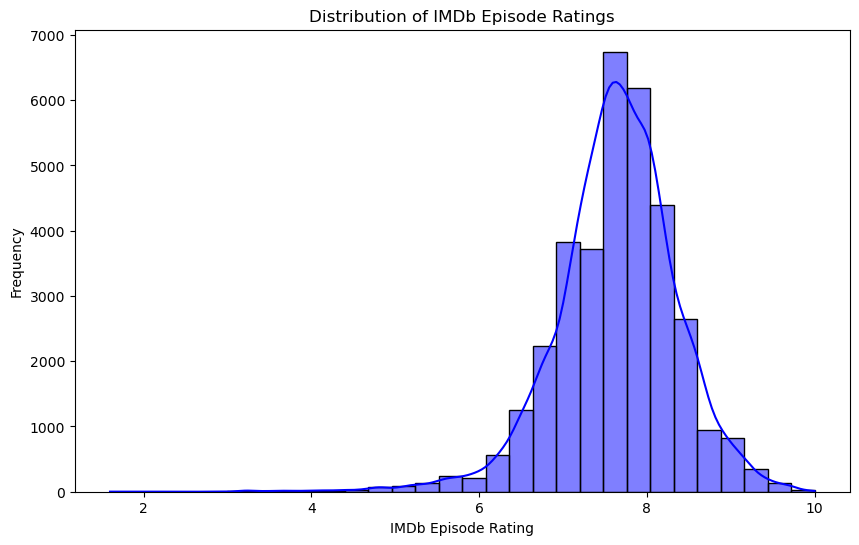

In [7]:
plt.figure(figsize=(10,6))
sns.histplot(df_imdb['averageRating_episode'], bins=30, kde=True, color="blue")
plt.xlabel("IMDb Episode Rating")
plt.ylabel("Frequency")
plt.title("Distribution of IMDb Episode Ratings")
plt.show()


/tmp/ipykernel_2269982/1035197458.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_imdb_exploded, x='genres', y='averageRating_episode', palette="coolwarm")


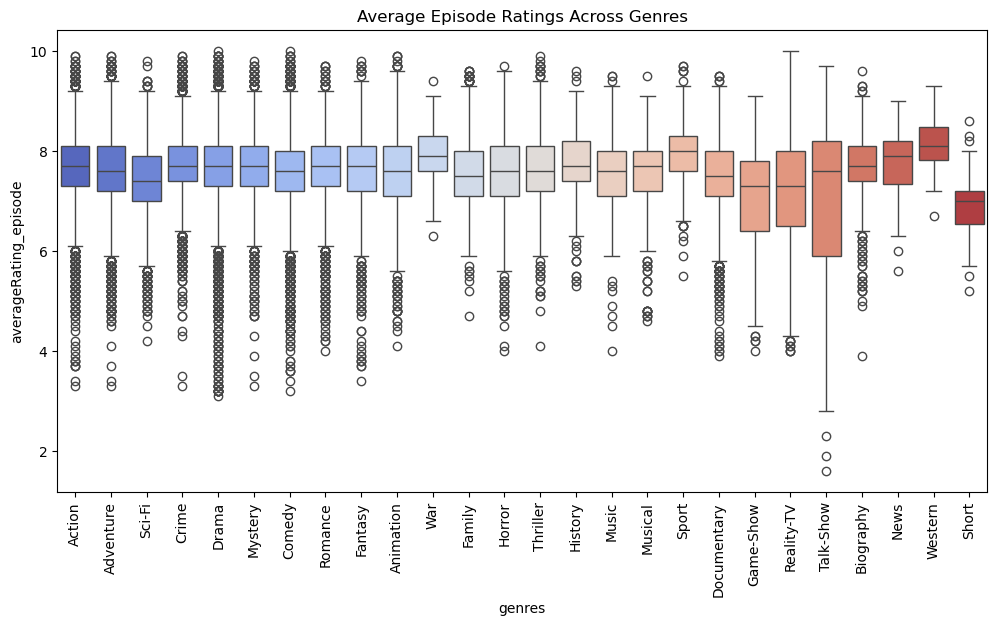

In [8]:
# Explode genres since multiple genres exist per row
df_imdb_exploded = df_imdb.assign(genres=df_imdb['genres'].str.split(',')).explode('genres')

plt.figure(figsize=(12,6))
sns.boxplot(data=df_imdb_exploded, x='genres', y='averageRating_episode', palette="coolwarm")
plt.xticks(rotation=90)
plt.title("Average Episode Ratings Across Genres")
plt.show()


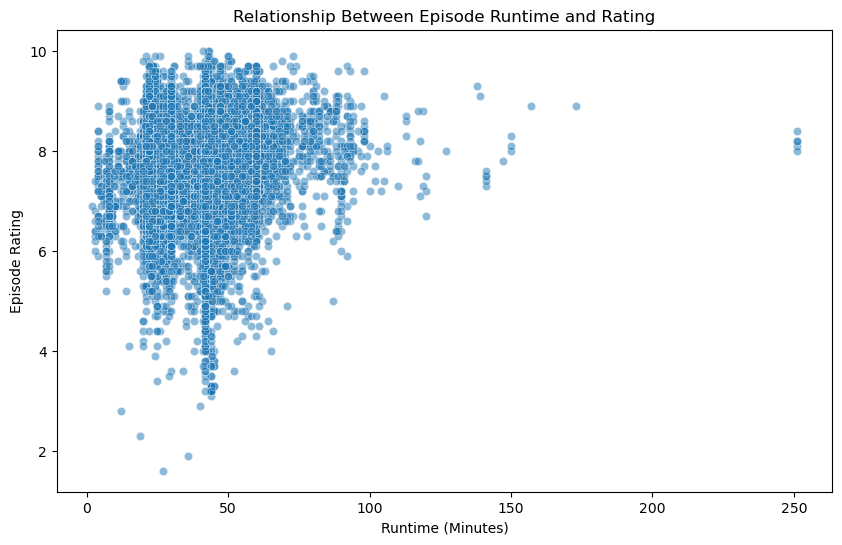

In [9]:
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_imdb['runtimeMinutes'], y=df_imdb['averageRating_episode'], alpha=0.5)
plt.xlabel("Runtime (Minutes)")
plt.ylabel("Episode Rating")
plt.title("Relationship Between Episode Runtime and Rating")
plt.show()


In [ ]:
# Convert the embedding strings to lists of floats
df_summarized["combined_embedding"] = df_summarized["combined_embedding"].apply(ast.literal_eval)

# Convert embeddings to numpy array
embeddings = np.array(df_summarized["combined_embedding"].tolist())

# Apply PCA to reduce to 2D for visualization
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Create a DataFrame for visualization
df_embeddings = pd.DataFrame(embeddings_2d, columns=["PC1", "PC2"])
df_embeddings["rating"] = df_imdb["averageRating_episode"][:len(df_embeddings)]

# Scatter plot of embeddings
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_embeddings, x="PC1", y="PC2", hue="rating", palette="coolwarm", alpha=0.6)
plt.title("2D Projection of Subtitle Embeddings")
plt.show()


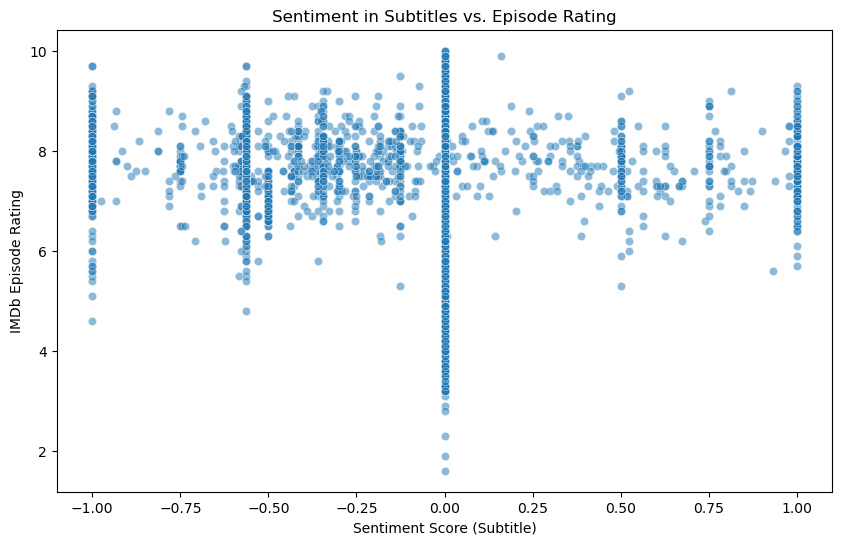

In [12]:
from textblob import TextBlob

df_subtitles["sentiment"] = df_subtitles["subtitles"].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_subtitles["sentiment"], y=df_imdb["averageRating_episode"], alpha=0.5)
plt.xlabel("Sentiment Score (Subtitle)")
plt.ylabel("IMDb Episode Rating")
plt.title("Sentiment in Subtitles vs. Episode Rating")
plt.show()


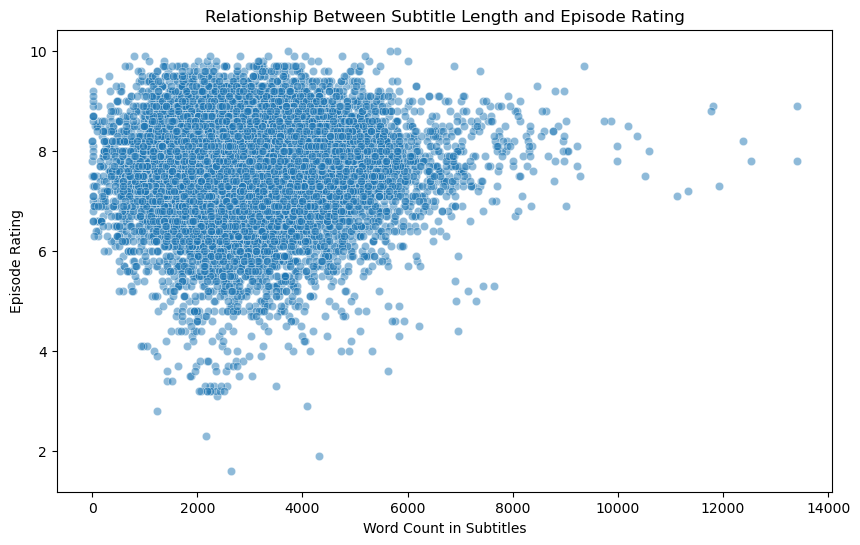

In [13]:
df_subtitles["word_count"] = df_subtitles["subtitles"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.scatterplot(x=df_subtitles["word_count"], y=df_imdb["averageRating_episode"], alpha=0.5)
plt.xlabel("Word Count in Subtitles")
plt.ylabel("Episode Rating")
plt.title("Relationship Between Subtitle Length and Episode Rating")
plt.show()


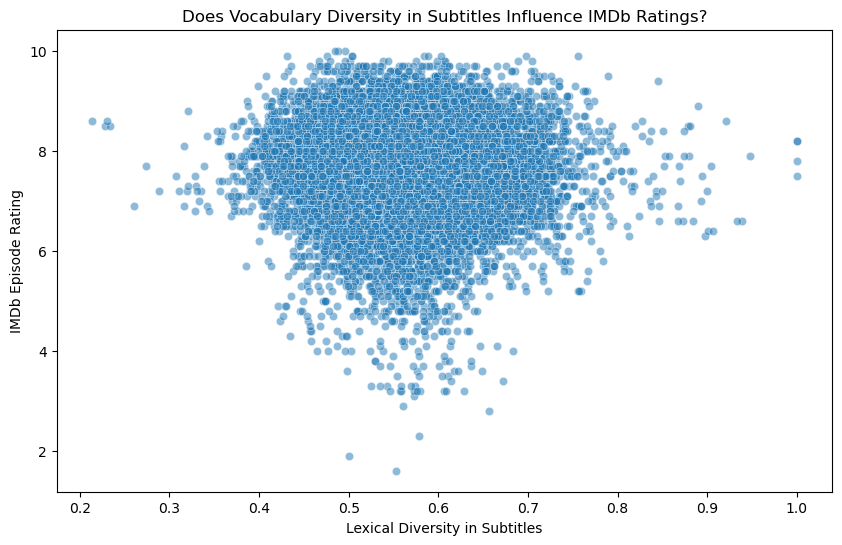

In [17]:
# Function to calculate lexical diversity
def lexical_diversity(text):
    words = str(text).split()
    return len(set(words)) / len(words) if len(words) > 0 else 0  # Unique words / Total words

df_subtitles["lexical_diversity"] = df_subtitles["subtitles"].apply(lexical_diversity)

# Plot lexical diversity vs. IMDb rating
plt.figure(figsize=(10,6))
sns.scatterplot(x=df_subtitles["lexical_diversity"], y=df_imdb["averageRating_episode"], alpha=0.5)
plt.xlabel("Lexical Diversity in Subtitles")
plt.ylabel("IMDb Episode Rating")
plt.title("Does Vocabulary Diversity in Subtitles Influence IMDb Ratings?")
plt.show()


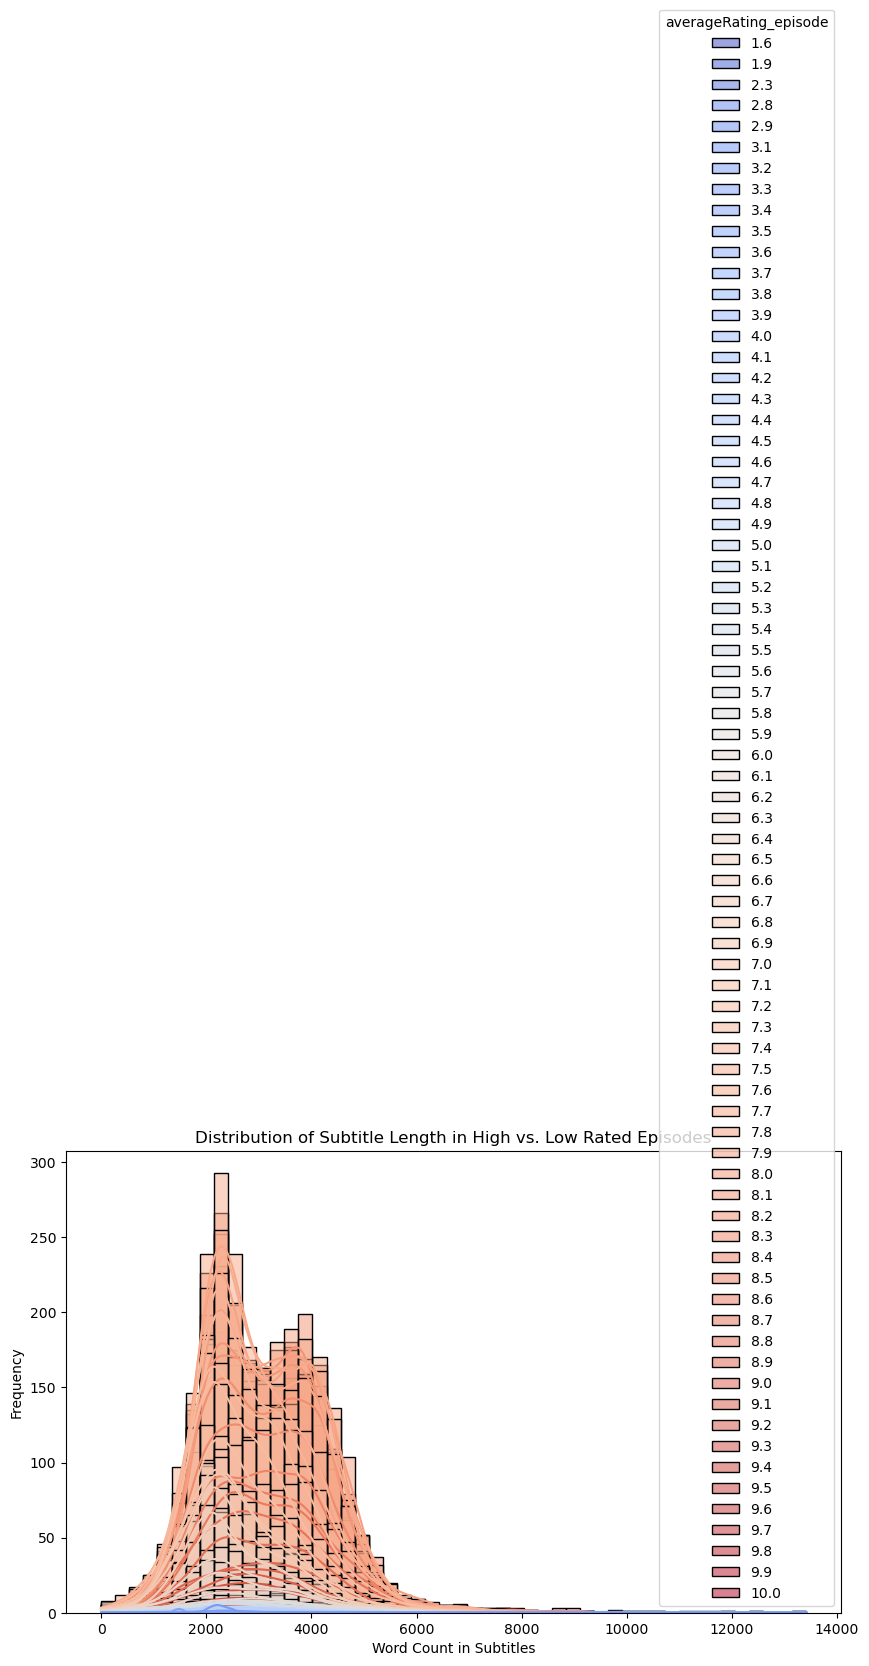

In [18]:
df_subtitles["word_count"] = df_subtitles["subtitles"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10,6))
sns.histplot(df_subtitles, x="word_count", hue=df_imdb["averageRating_episode"], bins=50, kde=True, palette="coolwarm")
plt.xlabel("Word Count in Subtitles")
plt.ylabel("Frequency")
plt.title("Distribution of Subtitle Length in High vs. Low Rated Episodes")
plt.show()


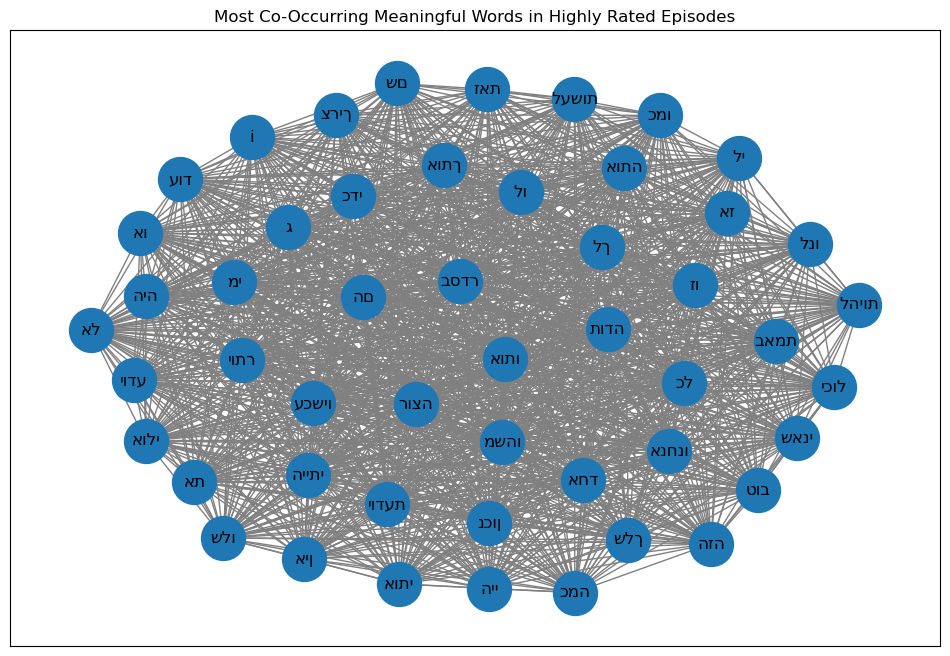

In [20]:
import networkx as nx
from collections import Counter
from itertools import combinations
import re

# Load Hebrew stopwords (adjust as needed)
hebrew_stopwords = set(["אני", "אתה", "של", "זה", "אבל", "אם", "הוא", "היא", "עם", "שלי", "יש", "לא", "כן", "בגלל", "מאוד", "על", "גם", "כאן", "כך", "כי", "מה", "למה", "איך", "רק", "אם", "שהוא", "שהיא", "שהם", "שזה"])

# Extract top-rated episodes' subtitles
high_rated_text = " ".join(df_subtitles[df_imdb["averageRating_episode"] >= 8]["subtitles"].dropna())

# Tokenize and remove stopwords
words = [word for word in re.findall(r'\b\w+\b', high_rated_text) if word not in hebrew_stopwords]

# Count word frequencies
word_freq = Counter(words)
top_words = [word for word, freq in word_freq.most_common(50)]  # Top 50 meaningful words

# Create word pairs (bigrams)
word_pairs = list(combinations(top_words, 2))

# Create graph
G = nx.Graph()
G.add_edges_from(word_pairs)

# Plot improved word network
plt.figure(figsize=(12,8))
nx.draw_networkx(G, with_labels=True, node_size=1000, font_size=12, edge_color="gray")
plt.title("Most Co-Occurring Meaningful Words in Highly Rated Episodes")
plt.show()
